Parente 2025 – Global Pasture Watch
===

This notebook contains the xarray Dataset creation for the [Parente 2025 paper](https://zenodo.org/records/14926056). Currently the data is in embargo until July 30 2025, so this notebook is only concerned with the [pasture data](https://zenodo.org/records/14933679) which is already public.

In [ ]:
from pathlib import Path
import os
__file__ = globals()["_dh"][0]
scratchspace = Path(__file__).absolute().parent.parent / "scratchspace" / "one-shots" / "parente2025"
os.makedirs(scratchspace, exist_ok=True)
scratchspace

# Maps of livestock headcount for 2000—2022 (FAOSTAT-adjusted)
EMBARGOED

# Maps of livestock density for 2000—2022 (including prediction interval)
EMBARGOED

# Maps potential land for livestock production for 2000—2022 (including production systems)
First, we download the TIFFs. Then we load them all into xarray and combine them into one single Dataset.

In [2]:
files: list[Path] = []
for year in range(2000, 2023):
    filename = f"gpw_livestock.systems_grassland.cropland.rules_c_1km_{year}0101_{year}1231_go_epsg.4326_v1.tif"
    path = scratchspace / filename
    files.append(path)

In [3]:
# # Don't rerun unless downloading again! Commented to prevent that from happening
# from urllib.request import urlretrieve
# for filepath in files:
#     url = f"https://zenodo.org/records/14933679/files/{filepath.name}?download=1"
#     urlretrieve(url, filepath)

In [4]:
from datetime import datetime

import rioxarray
import zarr
import numpy as np
import pandas as pd
import xarray as xr

target_crs = "EPSG:4326"  # WGS84 Lat/Lon
def create_ds(p: Path) -> xr.Dataset:
    rds = rioxarray.open_rasterio(p, masked=True)
    rds_reprojected = rds.rio.reproject(target_crs)
    ds = rds_reprojected.to_dataset(name="headcount")
    return ds

# Clean up the data so that it matches dClimate conventions
def standardize(ds: xr.Dataset, dt: datetime):
    ds = ds.drop_vars("spatial_ref")
    ds = ds.drop_vars("band")
    ds = ds.isel(band=0) # do selection to completely remove the band variable
    
    # add time dimension
    pd_date = pd.to_datetime(dt)
    ds = ds.expand_dims(time=[pd_date])
    
    del ds.x.attrs["axis"]
    del ds.y.attrs["axis"]
    ds = ds.rename({"x": "longitude", "y": "latitude"})
    ds = ds.sortby("latitude", ascending=True)
    ds = ds.sortby("longitude", ascending=True)

    da = ds.headcount
    da.encoding["compressors"] = zarr.codecs.BloscCodec()
    da.encoding["_FillValue"] = np.nan
    
    for attr in list(da.attrs.keys()):
        del da.attrs[attr]

    return ds

In [5]:
dses: list[xr.Dataset] = []
# Opening all files would takes a ton of RAM, so just open 2 files instead
# for i in range(0, len(files)):
for i in range(0, 2):
    filepath = files[i]
    year = 2000+i
    ds = create_ds(filepath)
    ds = standardize(ds, datetime(year, 1, 1))
    dses.append(ds)

In [6]:
ds = xr.concat(dses, dim="time")

In [7]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:    (time: 2, latitude: 14501, longitude: 39773)
Coordinates:
  * time       (time) datetime64[ns] 16B 2000-01-01 2001-01-01
  * longitude  (longitude) float64 318kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * latitude   (latitude) float64 116kB -55.99 -55.99 -55.98 ... 75.24 75.25
Data variables:
    headcount  (time, latitude, longitude) float32 5GB nan nan nan ... nan nan

In [9]:
nyc = ds.sel(time="2000-01-01", longitude=slice(-76, -71), latitude=slice(39, 42))
nyc

<xarray.Dataset> Size: 739kB
Dimensions:    (latitude: 331, longitude: 553)
Coordinates:
    time       datetime64[ns] 8B 2000-01-01
  * longitude  (longitude) float64 4kB -76.0 -75.99 -75.98 ... -71.01 -71.0
  * latitude   (latitude) float64 3kB 39.01 39.02 39.03 ... 41.98 41.99 41.99
Data variables:
    headcount  (latitude, longitude) float32 732kB nan 4.0 4.0 ... nan nan nan

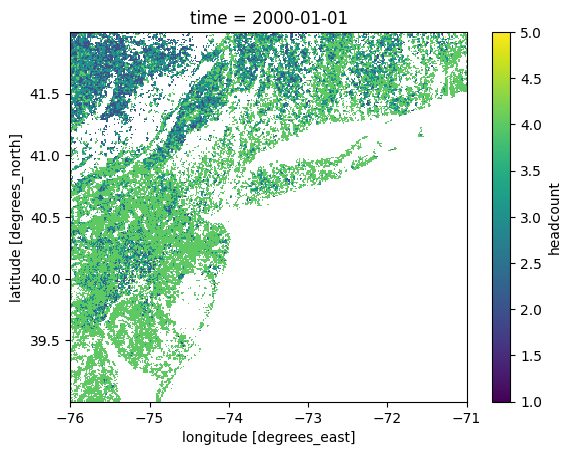

In [11]:
nyc.headcount.plot()